## Raw data from yfinance

/var/folders/lt/wvv2mw8n0y53nggq5dc55zwr0000gn/T/ipykernel_1422/2604204077.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(fname, parse_dates=True, index_col=0)
/var/folders/lt/wvv2mw8n0y53nggq5dc55zwr0000gn/T/ipykernel_1422/2604204077.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/var/folders/lt/wvv2mw8n0y53nggq5dc55zwr0000gn/T/ipykernel_1422/2604204077.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d", progress=False)
/var/folders/lt/wvv2mw8n0y53nggq5dc55zwr0000gn/T/ipykernel_1422/2604204077.py:174: FutureWarning: Calling float on a single element S


Results:
          Ticker        Date             S  MarketPrice  ImpliedVol_pct  \
0        SBIN.NS  2024-12-20    796.016357         45.0       47.398529   
1   ICICIBANK.NS  2024-12-20   1278.534790         60.0       38.958846   
2    HDFCBANK.NS  2024-12-20    873.937012         70.0       68.134896   
3    AXISBANK.NS  2024-12-20   1070.934692         55.0       42.850322   
4  BANKBARODA.NS  2024-12-20    232.574814         18.0       65.754153   
5       ^NSEBANK  2024-12-20  50759.199219        100.0             NaN   

   HistVol_pct  GARCH_5d_pct  
0    33.868228     31.460796  
1    31.530910     22.307222  
2    22.696946     18.834729  
3    33.697550     26.698497  
4    42.967991     41.436549  
5    24.531458     19.032692  


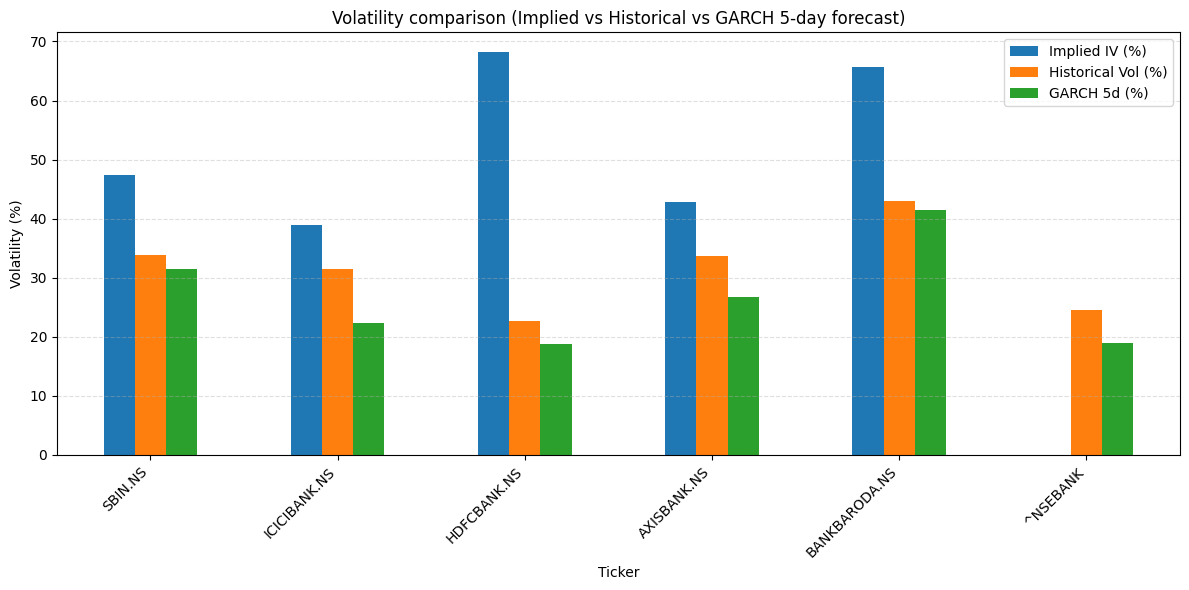


Saved results to bank_vol_results.csv


In [1]:
# bank_vol_cache.py
import os
import re
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
from arch import arch_model
import matplotlib.pyplot as plt

# ---------- User settings ----------
CSV_FILE = "bank_options.csv"
CACHE_DIR = "data_cache-10"
start_buffer_days = 3650  # how many days of history to fetch for returns/GARCH
risk_free_rate = 0.06    # annual risk-free rate to use in Black-Scholes (change if needed)
banknifty_market_price = 100.0  # fallback constant option premium for Bank Nifty (if CSV empty)
option_T_days = 30       # time to expiry in days assumed for IV calc
# -----------------------------------

os.makedirs(CACHE_DIR, exist_ok=True)

def safe_filename_from_ticker(ticker):
    """Convert ticker like 'SBIN.NS' -> 'SBIN.csv', '^NSEBANK' -> 'NSEBANK.csv'"""
    t = str(ticker).strip()
    # remove leading ^ if present
    if t.startswith("^"):
        t = t[1:]
    # remove common suffix .NS
    t = re.sub(r"\.NS$", "", t, flags=re.IGNORECASE)
    # replace other non-alnum with underscore
    t = re.sub(r"[^A-Za-z0-9_-]", "_", t)
    return f"{t}.csv"

def read_cache(ticker):
    fname = os.path.join(CACHE_DIR, safe_filename_from_ticker(ticker))
    if os.path.exists(fname):
        try:
            df = pd.read_csv(fname, parse_dates=True, index_col=0)
            # ensure index is datetime
            df.index = pd.to_datetime(df.index)
            return df, fname
        except Exception:
            return None, fname
    return None, fname

def write_cache(ticker, df):
    fname = os.path.join(CACHE_DIR, safe_filename_from_ticker(ticker))
    # Ensure index is datetime and sorted
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.duplicated(keep="last")]
    df = df.sort_index()
    df.to_csv(fname)
    return fname

def download_range(ticker, start_dt, end_dt):
    """
    Download history for ticker between start_dt (inclusive) and end_dt (exclusive).
    start_dt/end_dt are strings 'YYYY-MM-DD' or datetime.date/datetime.
    """
    start = pd.to_datetime(start_dt).strftime("%Y-%m-%d")
    end = pd.to_datetime(end_dt).strftime("%Y-%m-%d")
    df = yf.download(ticker, start=start, end=end, interval="1d", progress=False)
    if df is None or df.empty:
        return pd.DataFrame()  # empty
    df.index = pd.to_datetime(df.index)
    return df

def ensure_cached_history(ticker, required_start_date, required_end_date):
    """
    Ensure the cached CSV for ticker contains history covering required_start_date .. required_end_date.
    Returns a DataFrame with at least that range (may contain more).
    Dates can be 'YYYY-MM-DD' strings or datetime.date.
    """
    # Normalise to timestamps
    req_start = pd.to_datetime(required_start_date)
    # For end, we'll treat required_end_date exclusive (yfinance end param is exclusive), but for availability checks inclusive is fine.
    req_end = pd.to_datetime(required_end_date)

    cached_df, fname = read_cache(ticker)
    if cached_df is None or cached_df.empty:
        # Download full required window (plus a tiny buffer)
        dl_start = (req_start - pd.Timedelta(days=3)).strftime("%Y-%m-%d")
        dl_end = (req_end + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
        new_df = download_range(ticker, dl_start, dl_end)
        if new_df.empty:
            return pd.DataFrame()  # nothing available
        write_cache(ticker, new_df)
        return new_df

    # Determine missing parts
    cached_start = cached_df.index.min()
    cached_end = cached_df.index.max()
    to_merge = cached_df.copy()

    # If cached doesn't cover the left part
    if req_start < cached_start:
        dl_start = (req_start - pd.Timedelta(days=3)).strftime("%Y-%m-%d")
        dl_end = (cached_start + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
        left = download_range(ticker, dl_start, dl_end)
        if not left.empty:
            to_merge = pd.concat([left, to_merge])
    # If cached doesn't cover the right part
    if req_end > cached_end:
        dl_start = (cached_end - pd.Timedelta(days=1)).strftime("%Y-%m-%d")
        dl_end = (req_end + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
        right = download_range(ticker, dl_start, dl_end)
        if not right.empty:
            to_merge = pd.concat([to_merge, right])

    if to_merge.empty:
        return pd.DataFrame()
    # Clean and persist
    to_merge.index = pd.to_datetime(to_merge.index)
    to_merge = to_merge[~to_merge.index.duplicated(keep="last")].sort_index()
    write_cache(ticker, to_merge)
    # Return slice covering requested range (inclusive)
    slice_df = to_merge.loc[(to_merge.index >= req_start) & (to_merge.index <= req_end)]
    # If slice empty, still return the available to_merge (caller will handle missing data)
    if slice_df.empty:
        return to_merge
    return to_merge

# --- Black-Scholes, IV, vol functions (same as before) ---
def black_scholes_call(S, K, T, r, sigma):
    if sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_volatility_call(market_price, S, K, T, r):
    if market_price is None or np.isnan(market_price) or market_price <= 0 or S <= 0 or K <= 0:
        return np.nan
    objective = lambda sigma: black_scholes_call(S, K, T, r, sigma) - market_price
    try:
        iv = brentq(objective, 1e-6, 5.0, maxiter=200)
        return iv
    except Exception:
        return np.nan

def calc_historical_annualized_vol(returns, trading_days=252):
    return returns.std(ddof=1) * np.sqrt(trading_days)

def fit_garch_forecast(returns, horizon=5, trading_days=252):
    if len(returns) < 30:
        return np.nan
    try:
        am = arch_model(returns * 100.0, vol="GARCH", p=1, q=1, mean="Zero", dist="normal")
        res = am.fit(disp="off")
        fcast = res.forecast(horizon=horizon, reindex=False)
        var_vals = fcast.variance.values[-1]
        avg_daily_var_percent2 = np.mean(var_vals)
        avg_daily_std_decimal = np.sqrt(avg_daily_var_percent2) / 100.0
        return avg_daily_std_decimal * np.sqrt(trading_days)
    except Exception:
        return np.nan

# --- Helper: get close on or before a date using cached history ---
def get_close_on_or_before_using_cache(ticker, date_str):
    req_date = pd.to_datetime(date_str).date()
    # Ensure cached history covers req_date +- small buffer
    hist = ensure_cached_history(ticker, (req_date - dt.timedelta(days=10)).strftime("%Y-%m-%d"),
                                 (req_date + dt.timedelta(days=1)).strftime("%Y-%m-%d"))
    if hist is None or hist.empty:
        raise ValueError(f"No historical data available for {ticker} around {date_str}")
    hist.index = pd.to_datetime(hist.index).date
    available = [d for d in hist.index if d <= req_date]
    if not available:
        raise ValueError(f"No available close on or before {date_str} for {ticker}")
    last_date = max(available)
    return float(hist.loc[last_date]["Close"]), last_date, hist

# --- Main program ---
if not os.path.exists(CSV_FILE):
    raise FileNotFoundError(f"{CSV_FILE} not found. Please create the CSV as described and re-run.")

df_input = pd.read_csv(CSV_FILE, comment="#", skip_blank_lines=True)
required_cols = ["Date", "Ticker"]
for c in required_cols:
    if c not in df_input.columns:
        raise ValueError(f"CSV must contain column '{c}'")

df_input = df_input.rename(columns=lambda x: x.strip())

results = []
for idx, row in df_input.iterrows():
    date_str = str(row["Date"]).strip()
    ticker = str(row["Ticker"]).strip()
    market_price = None
    if "MarketPrice" in df_input.columns:
        try:
            v = row["MarketPrice"]
            if pd.notna(v) and v != "":
                market_price = float(v)
        except Exception:
            market_price = None

    if ticker.upper() in ["^NSEBANK", "NSEBANK", "BANKNIFTY"] and (market_price is None or np.isnan(market_price)):
        market_price = banknifty_market_price

    # Get close on or before date using caching
    try:
        S, used_date, hist_all = get_close_on_or_before_using_cache(ticker, date_str)
    except Exception as e:
        print(f"Skipping {ticker} on {date_str}: {e}")
        continue

    # For volatility/GARCH we need a longer history (start_buffer_days before date)
    req_start = (pd.to_datetime(date_str).date() - dt.timedelta(days=start_buffer_days)).strftime("%Y-%m-%d")
    req_end = (pd.to_datetime(date_str).date() + dt.timedelta(days=1)).strftime("%Y-%m-%d")
    hist_full = ensure_cached_history(ticker, req_start, req_end)
    if hist_full is None or hist_full.empty:
        print(f"No sufficient history for {ticker}; skipping")
        continue

    hist_full = hist_full.copy()
    hist_full["Return"] = hist_full["Close"].pct_change()
    returns = hist_full["Return"].dropna()
    hist_vol = calc_historical_annualized_vol(returns)

    garch_5day = fit_garch_forecast(returns, horizon=5)

    # IV assume ATM K = S and T = option_T_days / 365
    K = S
    T = option_T_days / 365.0
    iv = implied_volatility_call(market_price, S, K, T, risk_free_rate) if market_price is not None else np.nan

    results.append({
        "Ticker": ticker,
        "Date": date_str,
        "UsedPriceDate": str(used_date),
        "S": S,
        "MarketPrice": market_price,
        "ImpliedVol": iv,
        "HistVol": hist_vol,
        "GARCH_5d": garch_5day
    })

# Results DataFrame & plotting (same as earlier)
res_df = pd.DataFrame(results)
for col in ["ImpliedVol", "HistVol", "GARCH_5d"]:
    if col in res_df.columns:
        res_df[col + "_pct"] = res_df[col] * 100.0

print("\nResults:")
print(res_df[["Ticker", "Date", "S", "MarketPrice", "ImpliedVol_pct", "HistVol_pct", "GARCH_5d_pct"]])

plot_df = res_df.set_index("Ticker")[["ImpliedVol_pct", "HistVol_pct", "GARCH_5d_pct"]].fillna(0)
plot_df.columns = ["Implied IV (%)", "Historical Vol (%)", "GARCH 5d (%)"]

ax = plot_df.plot(kind="bar", figsize=(12,6))
ax.set_ylabel("Volatility (%)")
ax.set_title("Volatility comparison (Implied vs Historical vs GARCH 5-day forecast)")
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

res_df.to_csv("bank_vol_results.csv", index=False)
print("\nSaved results to bank_vol_results.csv")


## Data features

In [2]:
# Complete, robust pipeline to load messy CSVs (like NSEBANK.csv), clean them,
# compute RL volatility/time-series features, save per-ticker CSVs, and plot.
#
# This cell also demonstrates on any *.csv present in either:
#   - '/mnt/data/data_cache-10' (your preferred cache directory), or
#   - '/mnt/data' (fallback for this demo environment).
#
# Outputs are saved under: '/mnt/data/rl_vol_features/'

import os
import re
import math
import glob
import warnings
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import arch for GARCH; fall back to EWMA if unavailable
try:
    from arch import arch_model
    HAVE_ARCH = True
except Exception:
    HAVE_ARCH = False
    warnings.warn("Package 'arch' not available. Using EWMA (RiskMetrics) volatility as a proxy for GARCH.")

# ---------------------------
# Config
# ---------------------------
PREF_IN_DIRS = ["data_cache-10", "data"]  # will use the first that exists and has CSVs
OUT_DIR = "rl_vol_features"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Utilities
# ---------------------------
def _coerce_numeric(s: pd.Series) -> pd.Series:
    """Coerce an object series with commas, spaces, or stray symbols to numeric."""
    if s.dtype.kind in "biufc":
        return s.astype(float)
    # convert to string, strip commas/spaces
    cleaned = (
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("\u00a0", "", regex=False)  # non-breaking space
         .str.replace(" ", "", regex=False)
         .str.replace("%", "", regex=False)
    )
    return pd.to_numeric(cleaned, errors="coerce")

def _likely_date_col(df: pd.DataFrame) -> Optional[str]:
    """Find a column that parse as dates for majority of rows."""
    for col in df.columns:
        parsed = pd.to_datetime(df[col], errors="coerce")
        if parsed.notna().mean() > 0.8:
            return col
    return None

def _drop_leading_header_rows(df: pd.DataFrame) -> pd.DataFrame:
    """Drop 1-3 leading rows if they look like embedded headers/tickers (e.g., '^NSEBANK')."""
    df2 = df.copy()
    # If first row contains 'Ticker' or index/column names, drop it
    head_vals = df2.iloc[0].astype(str).str.upper().tolist()
    if any(v.startswith("^") or "TICKER" in v for v in head_vals):
        df2 = df2.iloc[1:].reset_index(drop=True)
    # If after dropping, first row contains 'Date' literal in first col, drop it
    if df2.shape[0] and str(df2.iloc[0,0]).strip().lower() in {"date","dates"}:
        df2 = df2.iloc[1:].reset_index(drop=True)
    return df2

def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names: strip, lower, unify variants."""
    ren = {c: re.sub(r"\s+", "_", c.strip()) for c in df.columns}
    df = df.rename(columns=ren)
    # common variants
    mapping = {
        "adj_close": "adjclose",
        "adj._close": "adjclose",
        "adjclose": "adjclose",
        "price": "price",
        "close*": "close",
        "close": "close",
        "open": "open",
        "high": "high",
        "low": "low",
        "volume": "volume",
        "date": "date",
        "iv_30d": "iv_30d",
        "atm_iv_30d": "iv_30d",
        "iv": "iv_30d",
    }
    # apply mapping when keys exist
    newcols = {}
    for c in df.columns:
        base = c.lower()
        newcols[c] = mapping.get(base, base)
    return df.rename(columns=newcols)

def clean_prices_df(df_in: pd.DataFrame, ticker_hint: Optional[str] = None) -> pd.DataFrame:
    """
    Clean a raw dataframe that may have embedded headers/rows and odd columns.
    Output must contain 'Date' and 'Close' (title-case) and optional 'IV_30d' (decimal, annualized).
    """
    df = df_in.copy()
    df = _drop_leading_header_rows(df)
    df = _normalize_columns(df)

    # Identify date column
    date_col = None
    for cand in ["date"]:
        if cand in df.columns:
            date_col = cand
            break
    if date_col is None:
        guess = _likely_date_col(df)
        if guess is not None:
            date_col = guess
    if date_col is None:
        # sometimes first column holds dates with name like 'price' (as seen in NSEBANK)
        first = df.columns[0]
        if pd.to_datetime(df[first], errors="coerce").notna().mean() > 0.8:
            date_col = first

    if date_col is None:
        raise ValueError("Could not identify a date column. Please ensure the CSV has a Date column.")

    # Choose a close column
    close_col = None
    for cand in ["adjclose", "close"]:
        if cand in df.columns:
            close_col = cand
            break
    if close_col is None and "price" in df.columns:
        close_col = "price"  # last resort
    if close_col is None:
        # any numeric-looking column as fallback
        numerics = [c for c in df.columns if c != date_col]
        for c in numerics:
            if _coerce_numeric(df[c]).notna().mean() > 0.8:
                close_col = c
                break
    if close_col is None:
        raise ValueError("Could not find a usable Close/Price column.")

    # Build cleaned frame
    out = pd.DataFrame({
        "Date": pd.to_datetime(df[date_col], errors="coerce")
    })
    out["Close"] = _coerce_numeric(df[close_col])

    # If IV exists under a variant name, coerce it
    iv_col = None
    for cand in ["iv_30d"]:
        if cand in df.columns:
            iv_col = cand
            break
    if iv_col is not None:
        out["IV_30d"] = _coerce_numeric(df[iv_col])
        # If IVs look like percents (e.g., ~20 to 40), convert to decimals
        if out["IV_30d"].median(skipna=True) > 1.5:
            out["IV_30d"] = out["IV_30d"] / 100.0

    # Drop rows without Date or Close
    out = out.dropna(subset=["Date", "Close"])
    out = out.sort_values("Date").reset_index(drop=True)
    return out

# ---------------------------
# Feature formulas & helpers
# ---------------------------
def log_returns(prices: pd.Series) -> pd.Series:
    """r_t = ln(P_t / P_{t-1})"""
    return np.log(prices.astype(float)).diff()

def rolling_sma(series: pd.Series, window: int) -> pd.Series:
    return series.rolling(window).mean()

def annualize_vol(std_daily: pd.Series, trading_days: int = 252) -> pd.Series:
    return std_daily * math.sqrt(trading_days)

def hist_vol(logret: pd.Series, window: int, trading_days: int = 252) -> pd.Series:
    return annualize_vol(logret.rolling(window).std(), trading_days=trading_days)

def garch_cond_vol_daily(logret: pd.Series) -> pd.Series:
    r = logret.dropna() * 100.0  # % units for arch
    vol = pd.Series(index=logret.index, dtype=float)
    if HAVE_ARCH and len(r) > 100:
        try:
            am = arch_model(r, vol="GARCH", p=1, q=1, mean="zero", dist="normal")
            res = am.fit(disp="off")
            cond = res.conditional_volatility / 100.0
            vol.loc[cond.index] = cond.astype(float)
        except Exception as e:
            warnings.warn(f"GARCH fit failed ({e}). Falling back to EWMA.")
    if vol.isna().all():
        lam = 0.94
        prev_var = r.var() if r.var() > 0 else 1e-8
        ewma = []
        for val in r:
            prev_var = lam * prev_var + (1 - lam) * (val ** 2)
            ewma.append(prev_var)
        vol.loc[r.index] = (pd.Series(ewma, index=r.index).pow(0.5)) / 100.0
    return vol

def to_annual(vol_daily: pd.Series, trading_days: int = 252) -> pd.Series:
    return vol_daily * math.sqrt(trading_days)

def compute_features(df: pd.DataFrame, ticker: str, trading_days: int = 252) -> Tuple[pd.DataFrame, str]:
    out = df.copy()
    out["Date"] = pd.to_datetime(out["Date"])
    out = out.sort_values("Date").set_index("Date")

    # Returns & lags
    out["log_ret"] = log_returns(out["Close"])
    out["R_t-1"] = out["log_ret"].shift(1)
    out["R_t-5"] = out["log_ret"].rolling(5).sum().shift(1)
    out["R_t-20"] = out["log_ret"].rolling(20).sum().shift(1)

    # SMA + z-scores
    out["SMA20"] = rolling_sma(out["Close"], 20)
    out["SMA60"] = rolling_sma(out["Close"], 60)
    out["z_price_vs_SMA20"] = (out["Close"] - out["SMA20"]) / out["Close"].rolling(20).std()
    out["z_price_vs_SMA60"] = (out["Close"] - out["SMA60"]) / out["Close"].rolling(60).std()

    # HVs
    out["HV_10"] = hist_vol(out["log_ret"], 10, trading_days)
    out["HV_20"] = hist_vol(out["log_ret"], 20, trading_days)
    out["HV_60"] = hist_vol(out["log_ret"], 60, trading_days)

    # GARCH daily -> annual
    garch_daily = garch_cond_vol_daily(out["log_ret"])
    out["GARCH_ann"] = to_annual(garch_daily, trading_days)

    # IV handling (proxy if missing)
    if "IV_30d" not in out.columns or out["IV_30d"].isna().all():
        out["IV_30d"] = out["GARCH_ann"].ewm(span=10, adjust=False).mean() * 1.10

    # Spreads/ratios vs HV_20
    out["IV_minus_HV"] = out["IV_30d"] - out["HV_20"]
    out["IV_div_HV"] = out["IV_30d"] / out["HV_20"]

    keep = [
        "Close",
        "R_t-1","R_t-5","R_t-20",
        "z_price_vs_SMA20","z_price_vs_SMA60",
        "HV_10","HV_20","HV_60",
        "GARCH_ann","IV_30d","IV_minus_HV","IV_div_HV"
    ]
    out = out[keep].dropna()

    out_path = os.path.join(OUT_DIR, f"{ticker}_features.csv")
    out.to_csv(out_path, index=True)
    return out, out_path

def load_price_iv_csv(path: str, ticker_hint: Optional[str] = None) -> pd.DataFrame:
    df_raw = pd.read_csv(path)
    df = clean_prices_df(df_raw, ticker_hint=ticker_hint)
    # Prefer Close; if Close is empty, try to fallback to Price (already handled in cleaner)
    return df

# ---------------------------
# Run over available CSVs
# ---------------------------
# choose input directory
csv_files: List[str] = []
chosen_dir = None
for d in PREF_IN_DIRS:
    if os.path.isdir(d):
        files = glob.glob(os.path.join(d, "*.csv"))
        if files:
            chosen_dir = d
            csv_files = files
            break

if not csv_files:
    raise FileNotFoundError("No CSV files found in /mnt/data/data_cache-10 or /mnt/data. "
                            "Please place your <TICKER>.csv files there.")

generated = {}
for p in csv_files:
    ticker = os.path.splitext(os.path.basename(p))[0]
    try:
        df = load_price_iv_csv(p, ticker_hint=ticker)
        feats, path = compute_features(df, ticker)
        generated[ticker] = (feats, path)
    except Exception as e:
        print(f"[WARN] Skipping {p} due to error: {e}")

# ---------------------------
# Plotting (each on its own figure; no specific colors)
# ---------------------------
for t, (feats, path) in generated.items():
    # Close
    plt.figure(figsize=(10,4))
    feats["Close"].plot()
    plt.title(f"{t} Close"); plt.xlabel("Date"); plt.ylabel("Price")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"{t}_close.png")); plt.close()

    # Returns lags
    plt.figure(figsize=(10,4))
    feats[["R_t-1","R_t-5","R_t-20"]].plot()
    plt.title(f"{t} Return Lags"); plt.xlabel("Date"); plt.ylabel("Log return / sums")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"{t}_returns.png")); plt.close()

    # Z-scores
    plt.figure(figsize=(10,4))
    feats[["z_price_vs_SMA20","z_price_vs_SMA60"]].plot()
    plt.title(f"{t} Z-Scored Price vs SMA(20/60)"); plt.xlabel("Date"); plt.ylabel("Z-score")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"{t}_zscore.png")); plt.close()

    # HV
    plt.figure(figsize=(10,4))
    feats[["HV_10","HV_20","HV_60"]].plot()
    plt.title(f"{t} Historical Volatility (annualized)"); plt.xlabel("Date"); plt.ylabel("Vol")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"{t}_hv.png")); plt.close()

    # GARCH vs IV
    plt.figure(figsize=(10,4))
    feats[["GARCH_ann","IV_30d"]].plot()
    plt.title(f"{t} GARCH(1,1) Annualized vs IV_30d"); plt.xlabel("Date"); plt.ylabel("Vol")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"{t}_garch_iv.png")); plt.close()

    # IV-HV metrics
    plt.figure(figsize=(10,4))
    feats[["IV_minus_HV","IV_div_HV"]].plot()
    plt.title(f"{t} IV-HV spread and IV/HV ratio"); plt.xlabel("Date"); plt.ylabel("Value")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"{t}_ivhv.png")); plt.close()

#from ace_tools import display_dataframe_to_user
#for t, (feats, path) in generated.items():
#    display_dataframe_to_user(name=f"{t} RL Feature Panel (tail preview)", dataframe=feats.tail(15))

sorted(os.listdir(OUT_DIR))[:20], OUT_DIR


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)
/var/folders/lt/wvv2mw8n0y53nggq5dc55zwr0000gn/T/ipykernel_1422/2328041267.py:296: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,4))
/var/folders/lt/wvv2mw8n0y53nggq5dc55zwr0000gn/T/ipykernel_1422/2328041267.py:302: RuntimeWarni

(['.ipynb_checkpoints',
  'AXISBANK_close.png',
  'AXISBANK_features.csv',
  'AXISBANK_garch_iv.png',
  'AXISBANK_hv.png',
  'AXISBANK_ivhv.png',
  'AXISBANK_returns.png',
  'AXISBANK_zscore.png',
  'BANKBARODA_close.png',
  'BANKBARODA_features.csv',
  'BANKBARODA_garch_iv.png',
  'BANKBARODA_hv.png',
  'BANKBARODA_ivhv.png',
  'BANKBARODA_returns.png',
  'BANKBARODA_zscore.png',
  'HDFCBANK_close.png',
  'HDFCBANK_features.csv',
  'HDFCBANK_garch_iv.png',
  'HDFCBANK_hv.png',
  'HDFCBANK_ivhv.png'],
 'rl_vol_features')

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

## Strategy A

In [3]:
# Strategy A — Pooled training across all tickers (Q-learning & SARSA)
# Save outputs to /mnt/data/strategy-A-model/

import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

# ----------------- Config -----------------
FEATURE_DIR = "rl_vol_features"
FALLBACK_DIR = "data"
OUT_ROOT = "strategy-A-model"
MODEL_DIR = os.path.join(OUT_ROOT, "models")
PLOT_DIR  = os.path.join(OUT_ROOT, "plots")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# Features to include in the state (compact)
FEATURES = [
    "R_t-1", "R_t-5", "R_t-20",
    "z_price_vs_SMA20", "HV_20", "GARCH_ann", "IV_minus_HV"
]
N_BINS = 3  # terciles

# RL hyperparams (tune as needed)
ALPHA = 0.2
GAMMA = 0.97
EPSILON = 0.1
COST = 0.001  # transaction cost per unit change
TRAIN_SPLIT = 0.7
EPOCHS = 8   # increase for more training

ACTIONS = np.array([-1, 0, +1], dtype=int)  # SELL, HOLD, BUY

# ----------------- Helpers -----------------
def find_feature_files() -> Dict[str,str]:
    paths = {}
    for d in (FEATURE_DIR, FALLBACK_DIR):
        if os.path.isdir(d):
            for p in glob.glob(os.path.join(d, "*_features.csv")):
                ticker = os.path.basename(p).replace("_features.csv", "")
                paths[ticker] = p
    return paths

def load_features(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date").reset_index(drop=True)
    # Validate required columns
    needed = ["Date", "Close"] + FEATURES
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")
    # drop NaNs in used columns
    df = df[["Date","Close"] + FEATURES].dropna().reset_index(drop=True)
    return df

def compute_split_index(n: int, frac: float) -> int:
    return int(math.floor(n * frac))

def fit_bins(frames: List[pd.DataFrame], features: List[str], n_bins: int) -> Dict[str, np.ndarray]:
    pooled = pd.concat([f[features] for f in frames], axis=0, ignore_index=True)
    bins = {}
    for feat in features:
        qs = np.linspace(0, 1, n_bins+1)
        edges = np.unique(np.quantile(pooled[feat].values, qs))
        # handle degenerate constant columns
        if len(edges) <= 2 and np.allclose(edges.max(), edges.min()):
            v = edges[0]
            edges = np.array([v-1e-9, v, v+1e-9])
        bins[feat] = edges
    return bins

def digitize_row(row: pd.Series, bins: Dict[str, np.ndarray], features: List[str]) -> Tuple[int,...]:
    idxs = []
    for f in features:
        edges = bins[f]
        # digitize into 0..(n_bins-1)
        val = row[f]
        # np.digitize with interior edges
        b = np.digitize([val], edges[1:-1])[0]
        idxs.append(int(b))
    return tuple(idxs)

def tuple_to_state_index(tpl: Tuple[int,...], base:int) -> int:
    # mixed-radix to scalar index
    idx = 0
    m = 1
    for v in reversed(tpl):
        idx += v * m
        m *= base
    return int(idx)

# ----------------- Data loading & splits -----------------
paths = find_feature_files()
if not paths:
    raise FileNotFoundError("No *_features.csv found in FEATURE_DIR or FALLBACK_DIR. Run feature generation first.")

data = {}
for ticker, path in paths.items():
    try:
        data[ticker] = load_features(path)
    except Exception as e:
        print(f"[WARN] skipping {ticker}: {e}")

# build train/test splits per ticker
splits = {}
for tick, df in data.items():
    n = len(df)
    if n < 60:
        print(f"[WARN] {tick} has only {n} rows after dropna; skipping.")
        continue
    k = compute_split_index(n, TRAIN_SPLIT)
    splits[tick] = (df.iloc[:k].reset_index(drop=True), df.iloc[k:].reset_index(drop=True))

if not splits:
    raise RuntimeError("No ticker has sufficient rows for train/test split.")

# ----------------- Fit bins on pooled train -----------------
train_frames = [tr for tr,te in splits.values()]
BINS = fit_bins(train_frames, FEATURES, N_BINS)

# Save bins (per-feature arrays) for later reproducibility
np.savez(os.path.join(MODEL_DIR, "strategyA_bins.npz"), **{f: BINS[f] for f in BINS})

# ----------------- Q table init -----------------
N_STATES = (N_BINS ** len(FEATURES))
N_ACTIONS = len(ACTIONS)
Q_qlearn = np.zeros((N_STATES, N_ACTIONS), dtype=float)
Q_sarsa  = np.zeros((N_STATES, N_ACTIONS), dtype=float)

# ----------------- Episode rollout (one ticker episode) -----------------
def rollout_episode(df: pd.DataFrame, bins: Dict[str,np.ndarray], q_table: np.ndarray,
                    on_policy: bool, train: bool,
                    alpha: float, gamma: float, epsilon: float, cost: float) -> float:
    # states for t = 0..T-2 (action at t applies to price t->t+1)
    T = len(df)
    if T < 2:
        return 0.0
    states = [ tuple_to_state_index(digitize_row(df.iloc[t], bins, FEATURES), N_BINS) for t in range(T-1) ]
    prices = df["Close"].values
    position_prev = 0
    total_reward = 0.0

    def choose_action(state_index: int, eps: float, train_flag: bool) -> int:
        if train_flag and np.random.rand() < eps:
            return np.random.choice(N_ACTIONS)
        return int(np.argmax(q_table[state_index]))

    for t in range(len(states)):
        s = states[t]
        a = choose_action(s, epsilon, train)
        pos = ACTIONS[a]
        pnl = (prices[t+1] - prices[t]) * pos
        cost = cost * abs(pos - position_prev)
        r = pnl - cost
        total_reward += r

        if train:
            if t < len(states)-1:
                s_next = states[t+1]
                if on_policy:
                    a_next = choose_action(s_next, epsilon, train)
                    td_target = r + gamma * q_table[s_next, a_next]
                else:
                    td_target = r + gamma * np.max(q_table[s_next])
            else:
                td_target = r
            # update
            q_table[s, a] += alpha * (td_target - q_table[s, a])

        position_prev = pos

    return total_reward

# ----------------- Train pooled Q-learning & SARSA -----------------
tickers = list(splits.keys())
for epoch in range(EPOCHS):
    # randomize ticker order each epoch
    for tick in np.random.permutation(tickers):
        tr, _ = splits[tick]
        # Q-learning update (off-policy)
        rollout_episode(tr, BINS, Q_qlearn, on_policy=False, train=True,
                        alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON, cost=COST)
        # SARSA update (on-policy)
        rollout_episode(tr, BINS, Q_sarsa, on_policy=True, train=True,
                        alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON, cost=COST)

# ----------------- Save Q-tables and meta -----------------
np.savez(os.path.join(MODEL_DIR, "QLEARN_strategyA.npz"),
         q_table=Q_qlearn, actions=ACTIONS, features=np.array(FEATURES, dtype=object),
         N_BINS=N_BINS)
np.savez(os.path.join(MODEL_DIR, "SARSA_strategyA.npz"),
         q_table=Q_sarsa, actions=ACTIONS, features=np.array(FEATURES, dtype=object),
         N_BINS=N_BINS)

# Also save a small metadata JSON for clarity
import json
meta = {
    "features": FEATURES,
    "n_bins": N_BINS,
    "actions": [-1,0,1],
    "alpha": ALPHA, "gamma": GAMMA, "epsilon": EPSILON, "cost": COST, "epochs": EPOCHS,
    "train_fraction": TRAIN_SPLIT
}
with open(os.path.join(MODEL_DIR, "strategyA_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

# ----------------- Backtest (Validation only: last 30%) and plotting -----------------
def greedy_action(q_table: np.ndarray, state_idx: int) -> int:
    return int(np.argmax(q_table[state_idx]))

def backtest_and_plot(ticker: str, df_test: pd.DataFrame, bins: Dict[str,np.ndarray], q_table: np.ndarray, name_suffix: str):
    # compute states and actions for t->t+1, produce DataFrame of signals aligned with test dates (except last row)
    T = len(df_test)
    if T < 2:
        return None
    states = [ tuple_to_state_index(digitize_row(df_test.iloc[t], bins, FEATURES), N_BINS) for t in range(T-1) ]
    prices = df_test["Close"].values
    pos_prev = 0
    actions_idx = []
    positions = []
    rewards = []
    for t in range(len(states)):
        s = states[t]
        a_idx = greedy_action(q_table, s)
        pos = ACTIONS[a_idx]
        pnl = (prices[t+1] - prices[t]) * pos
        cost = COST * abs(pos - pos_prev)
        r = pnl - cost
        actions_idx.append(a_idx)
        positions.append(pos)
        rewards.append(r)
        pos_prev = pos

    out = df_test.iloc[:-1].copy().reset_index(drop=True)
    out["action_idx"] = actions_idx
    out["position"] = positions
    out["reward"] = rewards
    out["signal"] = out["position"].map({-1:"SELL", 0:"HOLD", 1:"BUY"})

    # Save rewards CSV
    out_csv = os.path.join(MODEL_DIR, f"{ticker}_{name_suffix}_rewards.csv")
    out.to_csv(out_csv, index=False)

    # Plot price + markers for signals (validation period only)
    fig_path = os.path.join(PLOT_DIR, f"{ticker}_{name_suffix}_signals.png")
    plt.figure(figsize=(12,4))
    plt.plot(out["Date"], out["Close"], label="Close", color="blue", linewidth=1.2)
    #plt.plot(out["Date"], out["Close"], label="Close")
    # Markers for signals
    buys  = out[out["position"] == 1]
    sells = out[out["position"] == -1]
    holds = out[out["position"] == 0]

    # BUY = green up triangle, SELL = red down triangle, HOLD = gray dot (optional)
    if not buys.empty:
        plt.scatter(buys["Date"], buys["Close"], color="green", marker="^", label="BUY")
    if not sells.empty:
        plt.scatter(sells["Date"], sells["Close"], color="red", marker="v", label="SELL")
    if not holds.empty:
        plt.scatter(holds["Date"], holds["Close"], color="gray", marker=".", alpha=0.3, label="HOLD")
    ####
    #buys = out[out["position"]==1]
    #sells = out[out["position"]==-1]
    #holds = out[out["position"]==0]
    #if not buys.empty:
    #    plt.scatter(buys["Date"], buys["Close"], marker="^")
    #if not sells.empty:
    #    plt.scatter(sells["Date"], sells["Close"], marker="v")
    ####
    # holds may be many — we omit separate marker styling to avoid clutter; they remain in CSV
    plt.title(f"{ticker} - {name_suffix} signals (validation)")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.tight_layout()
    plt.savefig(fig_path)
    plt.close()

    return out
    
## Added helper function
def plot_combined_signals(ticker: str, df_q: pd.DataFrame, df_s: pd.DataFrame, outdir: str):
    """Overlay Q-learning and SARSA validation signals on one plot."""
    fig, ax = plt.subplots(figsize=(12,4))

    # Price (same in both)
    ax.plot(df_q["Date"], df_q["Close"], color="black", label="Close", linewidth=1.2)

    # Q-learning signals
    buys_q  = df_q[df_q["position"] == 1]
    sells_q = df_q[df_q["position"] == -1]
    ax.scatter(buys_q["Date"], buys_q["Close"], color="blue", marker="^", label="BUY (Q-learn)", alpha=0.6)
    ax.scatter(sells_q["Date"], sells_q["Close"], color="orange", marker="v", label="SELL (Q-learn)", alpha=0.6)

    # SARSA signals
    buys_s  = df_s[df_s["position"] == 1]
    sells_s = df_s[df_s["position"] == -1]
    ax.scatter(buys_s["Date"], buys_s["Close"], color="green", marker="^", label="BUY (SARSA)", alpha=0.6)
    ax.scatter(sells_s["Date"], sells_s["Close"], color="orange", marker="v", label="SELL (SARSA)", alpha=0.6)

    ax.set_title(f"{ticker} - Q-learning vs SARSA (validation)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc="best", fontsize=8)
    plt.tight_layout()
    combined_path = os.path.join(outdir, f"{ticker}_QvSARSA_combined.png")
    plt.savefig(combined_path)
    plt.close()
##

# Run backtest on each ticker's TEST and save plots
summary_rows = []
for tick, (tr, te) in splits.items():
    # use pooled bins and pooled Q-tables
    # Q-learning
    df_q = backtest_and_plot(tick, te, BINS, Q_qlearn, "QLEARN_strategyA")
    if df_q is not None:
        summary_rows.append((tick, "QLEARN_strategyA", df_q["reward"].sum(), df_q["reward"].mean(), len(df_q)))
    # SARSA
    df_s = backtest_and_plot(tick, te, BINS, Q_sarsa, "SARSA_strategyA")
    if df_s is not None:
        summary_rows.append((tick, "SARSA_strategyA", df_s["reward"].sum(), df_s["reward"].mean(), len(df_s)))
#Added for combination
df_q = backtest_and_plot(tick, te, BINS, Q_qlearn, "QLEARN_strategyA")
df_s = backtest_and_plot(tick, te, BINS, Q_sarsa, "SARSA_strategyA")

# Save summary
summary_df = pd.DataFrame(summary_rows, columns=["Ticker","Strategy","TotalReward","AvgReward","N_Steps"])
summary_df.to_csv(os.path.join(MODEL_DIR, "strategyA_backtest_summary.csv"), index=False)

# Combination
if df_q is not None and df_s is not None:
    plot_combined_signals(tick, df_q, df_s, PLOT_DIR)

print("Strategy A complete.")
print("Models saved in:", MODEL_DIR)
print("Plots saved in:", PLOT_DIR)
print("Summary saved to:", os.path.join(MODEL_DIR, "strategyA_backtest_summary.csv"))


Strategy A complete.
Models saved in: strategy-A-model/models
Plots saved in: strategy-A-model/plots
Summary saved to: strategy-A-model/models/strategyA_backtest_summary.csv
